# Gagnants Perdants

In [13]:
# | default_exp compare_before_after

In [14]:
# | export

import unittest
from typing import Dict

import numpy as np
from leximpact_common_python_libraries.logger import logger

from leximpact_socio_fisca_simu_etat.schema import CompareBeforeAfter

tc = unittest.TestCase()

In [15]:
# Activate multi-output in notebook
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [16]:
# | export
FOYERS_POTE = 39_818_220  # dans POTE 2020

SEUIL_SECRET = 12


class SecretViolationCompare(Exception):
    """
    Raised if the result of the simulation
    do not comform with regulators rules.
    """

    pass

## Somme les arrays

In [17]:
# | export


def sum_arrays(arrays_dict: Dict) -> np.array:
    """
    Sum the arrays in the disct one-by-one, ignoring 'weight'.
    """
    concat = None
    for k, v in arrays_dict.items():
        if k in ["weight"]:
            continue
        if concat is None:
            concat = np.zeros(np.shape(v))
        concat += v
    if concat is None:
        raise ValueError("Data is empty !")
    return concat

## Gagnants Perdants

In [58]:
# | export


def compare_before_after(
    before: Dict,
    after: Dict,
    weight: np.array = None,
    min_diff_factor: float = 1.05,
    weight_total_target: int = FOYERS_POTE,
    enforce_secret: bool = False,
    debug: bool = False,
) -> Dict:
    """
    Compare two dataset to evaluate the number of entity where values increase or decrease.

    The comparison support weigth of the entity.
    The could be in the dict or in parameter.

    We first sum all the data (except 'weight') one-by-one.
    So the name of the data is ignored.

    Arg:
        - before : The dict of data before. Example:
        {
            "avant": np.array([-100, -100, -100, -100, -100]),
            "weight": np.array([100, 100, 100, 100, 100]),
        }
        - after : The dict of data after. Same as before.

    Output:
        - A CompareBeforeAfter object of the comparison result.
    """
    before_concat, after_concat = sum_arrays(before), sum_arrays(after)
    tc.assertIsNotNone(before)
    tc.assertIsNotNone(after)
    if debug:
        logger.debug(
            f"compare_before_after : {before_concat.sum()=} {after_concat.sum()=}"
        )
    if weight is None:
        # Get weight from before dict
        # Will return None if no weight
        weight = before.get("weight")
    if weight is None:
        # Set all weight to 1
        weight = np.ones(np.shape(before_concat))
    if np.shape(before_concat) != np.shape(after_concat):
        raise ValueError(
            f"before({np.shape(before_concat)}) and after ({np.shape(after_concat)}) have different shape !"
        )
    total = sum(weight)
    if weight_total_target is None:
        weight_total_target = total
    weight_factor = weight_total_target / total
    total = total * weight_factor
    count_non_zero_before = (
        total
        - sum(weight * ((-0.9 < before_concat) & (before_concat < 0.9))) * weight_factor
    )
    count_non_zero_after = (
        total
        - sum(weight * ((-0.9 < after_concat) & (after_concat < 0.9))) * weight_factor
    )
    with np.errstate(divide="ignore", invalid="ignore"):
        above_after_no_weight = sum(abs(after_concat / before_concat) > min_diff_factor)
        lower_after_no_weight = sum(abs(before_concat / after_concat) > min_diff_factor)

        above_after = (
            sum(weight * (abs(after_concat / before_concat) > min_diff_factor))
            * weight_factor
        )
        lower_after = (
            sum(weight * (abs(before_concat / after_concat) > min_diff_factor))
            * weight_factor
        )
    if (
        (0 < abs(above_after_no_weight) < SEUIL_SECRET)
        or (0 < abs(lower_after_no_weight) < SEUIL_SECRET)
    ) and enforce_secret:
        raise SecretViolationCompare("Too few above after or lower after !")
    neutral = total - (above_after + lower_after)
    return CompareBeforeAfter(
        total=total,
        non_zero_before=count_non_zero_before,
        non_zero_after=count_non_zero_after,
        above_after=above_after,
        lower_after=lower_after,
        neutral=neutral,
        tolerance_factor_used=min_diff_factor,
        weight_factor=weight_factor,
    )

# TESTS

## Somme numpy arrays
### Only one array

In [59]:
array = np.array([-10, 0, 10, 2, 3, 4])
data_base = {
    "irpp": array,
}
c = sum_arrays(data_base)
tc.assertTrue((c == array).all())
tc.assertEqual(np.shape(c)[0], 6)

### Two arrays

In [60]:
data_base = {
    "irpp": np.array([-10, 0, 10, 2, 3, 4]),
    "irpp_economique": np.array([-1, 2, 3, 4, 5, 6]),
}

In [61]:
c = sum_arrays(data_base)
tc.assertTrue((c == np.array([-11.0, 2.0, 13.0, 6.0, 8.0, 10.0])).all())
tc.assertEqual(np.shape(c)[0], 6)

### With weight

Weight must not affect sum.

In [62]:
w = np.array([100, 100, 200, 100, 300, 300])
avant = {
    "irpp": np.array([-10, 0, 10, 2, 3, 4]),
    "irpp_economique": np.array([-1, 2, 3, 4, 5, 6]),
    "weight": w,
}
c = sum_arrays(avant)
tc.assertTrue((c == np.array([-11.0, 2.0, 13.0, 6.0, 8.0, 10.0])).all())

## Winners vs Loosers

In [63]:
b = np.array([-10, 0, 10, 2, 3, 4])
a = np.array([-10, 1, 12, 1, 3, 3])
w = np.array([100, 100, 200, 100, 300, 300])
supp = a > b
w * supp
supp_sum = sum(w * supp)
supp_sum

array([  0, 100, 200,   0,   0,   0])

300

### No weight

In [64]:
avant = {
    "avant": b,
}
apres = {
    "apres": a,
}
b
a
res = compare_before_after(
    avant,
    apres,
    min_diff_factor=1,
    weight_total_target=None,
    enforce_secret=False,
    debug=True,
)
tc.assertEqual(
    res.dict(),
    {
        "total": 6,  # Nombre d'éléments dans le tableau
        "non_zero_before": 5,
        "non_zero_after": 6,
        "above_after": 2,
        "lower_after": 2,
        "neutral": 2,
        "tolerance_factor_used": 1.0,
        "weight_factor": 1.0,
    },
)

array([-10,   0,  10,   2,   3,   4])

array([-10,   1,  12,   1,   3,   3])

[leximpact_socio-fisca-simu-etat DEBUG @ 11:05:20] compare_before_after : before_concat.sum()=9.0 after_concat.sum()=10.0


In [65]:
res = compare_before_after(avant, avant, min_diff_factor=1, weight_total_target=None)
res

CompareBeforeAfter(total=6, non_zero_before=5, non_zero_after=5, above_after=0, lower_after=0, neutral=6, tolerance_factor_used=1.0, weight_factor=1.0)

In [66]:
# Gagnants
factor = 1.2
print("before", b)
print("after", a)
# print("a/b :",(a/b))


# On veut que la différence entre avant et après soit au moins de 20%
# C'est à dire que si on passe de 10 à 12, c'est insuffisant  => False (cas 3)
# Mais de 0 à 1 c'est significatif => True. (cas 2)
# Et si on ne bouge pas, ça doit être neutre => False
# Donc on souhaite que le résultat de la division de avant / après soit suppéreur au facteur.

# res = np.ones( np.shape(a) )  #preinit
# np.divide(a,b, out=res, where=b!=0) #only divide nonzeros else 1
# res
with np.errstate(divide="ignore", invalid="ignore"):
    res = (a / b) > factor
res
tc.assertTrue((res == [False, True, False, False, False, False]).all())

before [-10   0  10   2   3   4]
after [-10   1  12   1   3   3]


array([False,  True, False, False, False, False])

In [67]:
# Perdants
factor = 1.2
print("before", b)
print("after", a)
with np.errstate(divide="ignore", invalid="ignore"):
    print("a/b :", (a / b))
    print("b/a :", (b / a))


# On veut que la différence entre avant et après soit au moins de 20%
# C'est à dire que si on passe de 2 à 1, c'est significatif => True. (cas 4)
# Et si on ne bouge pas, ça doit être neutre => False
# Donc on souhaite que le résultat de la division de après / avant soit suppéreur au facteur.

with np.errstate(divide="ignore", invalid="ignore"):
    res = (b / a) > factor
res
tc.assertTrue((res == [False, False, False, True, False, True]).all())

before [-10   0  10   2   3   4]
after [-10   1  12   1   3   3]
a/b : [1.    inf 1.2  0.5  1.   0.75]
b/a : [1.         0.         0.83333333 2.         1.         1.33333333]


array([False, False, False,  True, False,  True])

### Weight in parameter

In [68]:
res = compare_before_after(
    avant, apres, w, min_diff_factor=1, weight_total_target=None, enforce_secret=False
)
res
tc.assertEqual(res.total, sum(w))
tc.assertEqual(res.non_zero_before, sum(w) - 100)
tc.assertEqual(res.non_zero_after, sum(w))
tc.assertEqual(res.above_after, w[1] + w[2])
tc.assertEqual(res.lower_after, w[3] + w[-1])
tc.assertEqual(res.neutral, w[0] + w[-2])

CompareBeforeAfter(total=1100, non_zero_before=1000, non_zero_after=1100, above_after=300, lower_after=400, neutral=400, tolerance_factor_used=1.0, weight_factor=1.0)

### Weight in data

In [69]:
avant = {
    "avant": b,
    "weight": w,
}
apres = {
    "apres": a,
}
res = compare_before_after(
    avant, apres, min_diff_factor=1, weight_total_target=None, enforce_secret=False
)
res
tc.assertEqual(res.total, sum(w))
tc.assertEqual(res.non_zero_before, sum(w) - 100)
tc.assertEqual(res.non_zero_after, sum(w))
tc.assertEqual(res.above_after, w[1] + w[2])
tc.assertEqual(res.lower_after, w[3] + w[-1])
tc.assertEqual(res.neutral, w[0] + w[-2])

CompareBeforeAfter(total=1100, non_zero_before=1000, non_zero_after=1100, above_after=300, lower_after=400, neutral=400, tolerance_factor_used=1.0, weight_factor=1.0)

### Factor

In [70]:
np.where(b != 0, False, True)

array([False,  True, False, False, False, False])

In [71]:
res = compare_before_after(
    avant, apres, min_diff_factor=1.2, weight_total_target=None, enforce_secret=False
)
res
tc.assertEqual(res.total, sum(w))
tc.assertEqual(res.non_zero_before, sum(w) - 100)
tc.assertEqual(res.non_zero_after, sum(w))
# w[1]+w[2] => w[1] car 10+20%=12
tc.assertEqual(res.above_after, w[1])
tc.assertEqual(res.lower_after, w[3] + w[5])
tc.assertEqual(res.neutral, w[0] + w[2] + w[4])

CompareBeforeAfter(total=1100, non_zero_before=1000, non_zero_after=1100, above_after=100, lower_after=400, neutral=600, tolerance_factor_used=1.2, weight_factor=1.0)

In [72]:
avant = {
    "avant": np.array([100, 200, 300, 400, 500]),
    "weight": np.array([100, 100, 100, 100, 100]),
}
apres = {
    "apres": np.array([100, 204, 315, 400 * 1.06, 550]),
}
# Facteur 1 => 4 touchés
res = compare_before_after(
    avant, apres, min_diff_factor=1, weight_total_target=None, enforce_secret=False
)
res
tc.assertEqual(res.above_after, 400)
tc.assertEqual(res.lower_after, 0)
# Facteur 1.05 => 2 touchés : Il faut bien > 5% et pas >= 5%
res = compare_before_after(
    avant, apres, min_diff_factor=1.05, weight_total_target=None, enforce_secret=False
)
tc.assertEqual(res.above_after, 200)
# Facteur 1.10 => 0 touché : Il faut bien > 110
res = compare_before_after(
    avant, apres, min_diff_factor=1.10, weight_total_target=None, enforce_secret=False
)
tc.assertEqual(res.above_after, 0)

CompareBeforeAfter(total=500, non_zero_before=500, non_zero_after=500, above_after=400, lower_after=0, neutral=100, tolerance_factor_used=1.0, weight_factor=1.0)

### Tests with negatives numbers

In [75]:
avant = {
    "avant": np.array([-100, -100, -100, -100, -100]),
    "weight": np.array([100, 100, 100, 100, 100]),
}
apres = {
    "apres": np.array([-100, -104, -105, -106, -110]),
}
# Facteur 1 => 4 touchés
res = compare_before_after(
    avant, apres, min_diff_factor=1, weight_total_target=None, enforce_secret=False
)
tc.assertEqual(res.above_after, 400)
tc.assertEqual(res.lower_after, 0)
# Facteur 1.05 => 2 touchés : Il faut bien > 5% et pas >= 5%
res = compare_before_after(
    avant, apres, min_diff_factor=1.05, weight_total_target=None, enforce_secret=False
)
tc.assertEqual(res.above_after, 200)
# Facteur 1.10 => 0 touché : Il faut bien > 110
res = compare_before_after(
    avant, apres, min_diff_factor=1.10, weight_total_target=None, enforce_secret=False
)
tc.assertEqual(res.above_after, 0)
tc.assertEqual(res.lower_after, 0)

In [84]:
avant = {
    "avant": np.array([0, 0, 0, -100, -100]),
    "weight": np.array([100, 100, 100, 100, 100]),
}
apres = {
    "apres": np.array([-0.1, -104, -105, -106, -110]),
}
res = compare_before_after(
    avant, apres, min_diff_factor=1, weight_total_target=None, enforce_secret=False
)
tc.assertEqual(res.non_zero_before, 200)
tc.assertEqual(res.non_zero_after, 400)
res
tc.assertEqual(
    res.dict(),
    {
        "total": 500,
        "non_zero_before": 200,  # 2 * 100
        "non_zero_after": 400,  # 4 * 100, celui à -0.1 est ignoré
        "above_after": 500,  # 5 * 100
        "lower_after": 0,
        "neutral": 0,
        "tolerance_factor_used": 1.0,
        "weight_factor": 1.0,
    },
)

CompareBeforeAfter(total=500, non_zero_before=200, non_zero_after=400, above_after=500, lower_after=0, neutral=0, tolerance_factor_used=1.0, weight_factor=1.0)

In [88]:
avant = {
    "avant": np.array([0, -25, -50, -100, -500]),
    "weight": np.array([100, 100, 100, 100, 100]),
}
apres = {
    "apres": np.array([0, 0, -25, -50, -600]),
}
res = compare_before_after(
    avant, apres, min_diff_factor=1, weight_total_target=None, enforce_secret=False
)

tc.assertEqual(
    res.dict(),
    {
        "total": 500,
        "non_zero_before": 400,  # 4 * 100
        "non_zero_after": 300,  # 3 * 100
        "above_after": 100,  # 1 * 100, le dernier
        "lower_after": 300,  # 3 sont gagnats
        "neutral": 100,  # 1 reste à 0
        "tolerance_factor_used": 1.0,
        "weight_factor": 1.0,
    },
)

### Weight correction

In [77]:
res = compare_before_after(avant, apres, min_diff_factor=1, enforce_secret=False)
res
tc.assertEqual(res.total, FOYERS_POTE)
tc.assertEqual(res.above_after + res.lower_after + res.neutral, FOYERS_POTE)

CompareBeforeAfter(total=39818220, non_zero_before=15927288, non_zero_after=31854576, above_after=39818220, lower_after=0, neutral=0, tolerance_factor_used=1.0, weight_factor=79636.44)


### Problème en prod

Le 8/8/2023, en production, si on passe tout le barême à 0, on se retrouve bien avec un total d'IR à 0, mais pourtant:

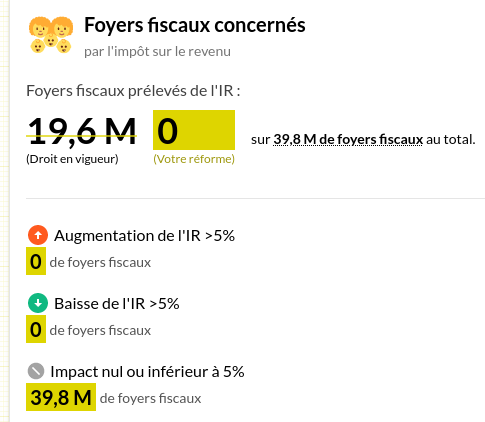

Le retour est faux :
```json
{
	"compare_before_after": {
		"total": 39818220,
		"non_zero_before": 19557167,
		"non_zero_after": 0,
		"above_after": 0,
		"lower_after": 0,
		"neutral": 39818220,
		"tolerance_factor_used": 1.05,
		"weight_factor": 1.0387458297329812
	}
}
```

- `lower_after` devrait être à 19 557 167 puisqu'ils sont tous à 0, soit ceux qui payaient de l'IR avant la réforme.
- `neutral` devrait être à `total - non_zero_before`, soit ceux qui ne payait pas d'IR avant la réforme.

Résolution : il manquait une mise en valeur absolue dans les calculs de `lower_after` et `above_after` !

In [79]:
avant = {
    "avant": np.array([0, 0, 0, -100, -100]),
    "weight": np.array([100, 100, 100, 100, 100]),
}
apres = {
    "apres": np.array([0, 0, 0, 0, 0]),
}
res = compare_before_after(
    avant,
    apres,
    min_diff_factor=1,
    weight_total_target=None,
    enforce_secret=False,
    debug=True,
)
res
tc.assertEqual(res.non_zero_before, 200)
tc.assertEqual(res.non_zero_after, 0)

[leximpact_socio-fisca-simu-etat DEBUG @ 11:06:32] compare_before_after : before_concat.sum()=-200.0 after_concat.sum()=0.0


CompareBeforeAfter(total=500, non_zero_before=200, non_zero_after=0, above_after=0, lower_after=200, neutral=300, tolerance_factor_used=1.0, weight_factor=1.0)

In [80]:
weight = avant["weight"]
before_concat = avant["avant"]
after_concat = apres["apres"]
weight_factor = 1
with np.errstate(divide="ignore", invalid="ignore"):
    lower_after = sum(weight * ((before_concat / after_concat) > 1.05)) * weight_factor
after_concat
lower_after

array([0, 0, 0, 0, 0])

0

In [57]:
with np.errstate(divide="ignore", invalid="ignore"):
    (before_concat / after_concat)
    abs(before_concat / after_concat) > 1.05

array([ nan,  nan,  nan, -inf, -inf])

array([False, False, False,  True,  True])

## Error cases

In [36]:
tc.assertRaises(ValueError, compare_before_after, {"weight": [0]}, {"weight": [0]})

In [37]:
tc.assertRaises(ValueError, compare_before_after, {"irpp": [0, 1]}, {"irpp": [0]})

In [38]:
tc.assertRaises(ValueError, compare_before_after, {"irpp": [0, 1]}, {"irpp": [0]})